In [1]:
# pylint: disable=too-many-arguments, too-many-locals
""" Variational inference """
import math
import functools
from collections import namedtuple
from collections import OrderedDict
from scipy.special import gammaln
import numpy as np

import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

VariationalParameter = namedtuple('VariationalParameter',
                                  ['mean', 'rho', 'eps'])


def evaluate(variational_parameter):
    """ Evaluates the current value of a variational parameter.
    Returns mean + log(1 + e^rho) * eps
    :args variational_parameter: the variational parameter
    :returns: the value of the variational parameter
    """
    assert isinstance(variational_parameter, VariationalParameter), \
        "Incorrect type."
    return variational_parameter.mean + \
        (1 + variational_parameter.rho.exp()).log() * variational_parameter.eps


def rebuild_parameters(dico, module, epsilon_setting):
    """ Rebuild parameters.
    Build the computational graph corresponding to
    the computations of the parameters of the given module,
    using the corresponding variational parameters in dico,
    and the rule used to sample epsilons. If the module has
    submodules, corresponding subcomputational graphs are also
    built.
    Typically, if a module has a parameter weight, weight should
    appear in dico, and the parameter will be rebuilt as
    module.weight = dico['weight'].mean + (1+dico['weight'].rho.exp()).log() *
            dico['weight'].eps
    :args dico: a 'tree' dictionnary that contains variational
    parameters for the current module, and subtrees for submodules
    :args module: the module whose parameters are to be rebuilt
    :args epsilon_settings: how epsilons ought to be drawn
    """

    for name, p in dico.items():
        if isinstance(p, VariationalParameter):
            if p.eps is None:
                dico[name] = p._replace(eps=Variable(p.mean.data.clone()))
            epsilon_setting(name, dico[name])
            setattr(module, name, evaluate(dico[name]))
        elif p is None:
            setattr(module, name, None)
        else:
            rebuild_parameters(p, getattr(module, name), epsilon_setting)


def prior_std(p):
    """ Compute a reasonable prior standard deviation for parameter p.
    :args p: the parameter
    :return: the resulting std
    """
    stdv = 1
    if p.dim() > 1:
        for i in range(p.dim() - 1):
            stdv = stdv * p.size()[i + 1]
        stdv = 1 / math.sqrt(stdv)
    else:
        stdv = 1e-2
    return stdv


def sub_prior_loss(dico):
    """ Compute the KL divergence between prior and parameters for
    all Variational Parameters in the tree dictionary dico.
    :args dico: tree dictionary
    :return: KL divergence between prior and current
    """
    loss = 0
    for p in dico.values():
        if isinstance(p, VariationalParameter):
            mean = p.mean
            std = (1 + p.rho.exp()).log()
            std_prior = prior_std(mean)
            loss += (-(std / std_prior).log() +
                     (std.pow(2) + mean.pow(2)) /
                     (2 * std_prior ** 2) - 1 / 2).sum()
        else:
            loss += sub_prior_loss(p)
    return loss


def sub_entropy(dico):
    """ Compute the entropy of the parameters for all Variational
    Parameters in the tree dictionary dico.
    :args dico: tree dictionary
    :returns: Entropy of the current distribution
    """
    entropy = 0.
    for _, p in dico.items():
        if isinstance(p, VariationalParameter):
            std = (1 + p.rho.exp()).log()
            n = np.prod(std.size())
            entropy += std.log().sum() + .5 * n * (1 + np.log(2 * np.pi))
        else:
            entropy += sub_entropy(p)
    return entropy


def sub_conjprior(dico, alpha_0, beta_0, mu_0, kappa_0):
    """ Compute an estimation of the KL divergence between the conjugate
    prior and parameters for all Variational Parameters in the tree
    dictionary dico.
    :args dico: tree dictionary
    :args alpha_0: hyperparameter of the conjugate prior
    :args beta_0: hyperparameter of the conjugate prior
    :args mu_0: hyperparameter of the conjugate prior
    :args kappa_0: hyperparameter of the conjugate prior
    :return: estimation of the KL divergence between prior and current
    """
    logprior = 0.
    for _, p in dico.items():
        if isinstance(p, VariationalParameter):
            theta = evaluate(p)
            S = (theta.mean() - mu_0).norm() ** 2
            V = (theta - theta.mean()).norm() ** 2
            n = np.prod(theta.size())
            alpha_n = alpha_0 + n / 2
            kappa_n = kappa_0 + n
            beta_n = beta_0 + V / 2 + S * (kappa_0 * n) / (2 * kappa_n)
            logprior += - beta_n.log() * alpha_n + alpha_0 * np.log(beta_0) + \
                gammaln(alpha_n) - gammaln(alpha_0) + \
                .5 * np.log(kappa_0 / kappa_n) - .5 * n * np.log(2 * np.pi)

        else:
            logprior += sub_conjprior(
                p, alpha_0, beta_0, mu_0, kappa_0)
    return logprior


def sub_conjpriorknownmean(dico, mean, alpha_0, beta_0):
    """ Compute an estimation of the KL divergence between the conjugate
    prior when the mean is known and parameters for all Variational
    Parameters in the tree dictionary dico.
    :args dico: tree dictionary
    :args mean: known mean for the conjugate prior
    :args alpha_0: hyperparameter of the conjugate prior
    :args beta_0: hyperparameter of the conjugate prior
    :return: estimation of the KL divergence between prior and current
    """
    logprior = 0.
    for _, p in dico.items():
        if isinstance(p, VariationalParameter):
            theta = evaluate(p)
            S = (theta - mean).norm() ** 2
            n = np.prod(theta.size())
            alpha_n = alpha_0 + n / 2
            beta_n = beta_0 + S / 2
            logprior += - beta_n.log() * alpha_n + \
                gammaln(alpha_n) - gammaln(alpha_0) + \
                alpha_0 * np.log(beta_0) - .5 * n * np.log(2 * np.pi)
        else:
            logprior += sub_conjpriorknownmean(
                p, mean, alpha_0, beta_0)
    return logprior


def sub_mixtgaussprior(dico, sigma_1, sigma_2, pi):
    """ Compute an estimation of the KL divergence between the prior
    defined by the mixture of two gaussian distributions
    for all Variational Parameters in the tree dictionary dico.
    More details on this prior and the notations can be found in :
    "Weight Uncertainty in Neural Networks" Blundell et al, 2015
    https://arxiv.org/pdf/1505.05424.pdf
    :args dico: tree dictionary
    :args sigma_1: std of the first gaussian in the mixture
    :args sigma_2: std of the second gaussian in the mixture
    :args pi: probability of the first gaussian in the mixture
    :return: estimation of the KL divergence between prior and current
    """
    logprior = 0.
    for _, p in dico.items():
        if isinstance(p, VariationalParameter):
            theta = evaluate(p)
            n = np.prod(theta.size())
            theta2 = theta ** 2
            pgauss1 = (- theta2 / (2. * sigma_1 ** 2)).exp() / sigma_1
            pgauss2 = (- theta2 / (2. * sigma_2 ** 2)).exp() / sigma_2
            logprior += (pi * pgauss1 + (1 - pi) * pgauss2 + 1e-8).log().sum()
            logprior -= n / 2 * np.log(2 * np.pi)
        else:
            logprior += sub_mixtgaussprior(
                p, sigma_1, sigma_2, pi)
    return logprior


class Variationalize(nn.Module):
    """ Build a Variational model over the model given as input.
    Variationalize changes all parameters of the given model
    to allow learning of a gaussian distribution over the
    parameters using Variational inference. For more information,
    see e.g. https://papers.nips.cc/paper/4329-practical-variational
    -inference-for-neural-networks.pdf.
    :args model: the model on which VI is to be performed
    :args zero_mean: if True, sets initial mean to 0, else
        keep model initial mean
    :args learn_mean: if True, learn the posterior mean
    :args learn_rho: if True, learn the posterior rho
    """
    def __init__(self, model, zero_mean=True, learn_mean=True, learn_rho=True):
        super().__init__()
        self.model = model

        self.dico = OrderedDict()
        self._variationalize_module(self.dico, self.model, '', zero_mean,
                                    learn_mean, learn_rho)
        self._prior_loss_function = functools.partial(
            sub_prior_loss,
            dico=self.dico)

    def _variationalize_module(self, dico, module, prefix, zero_mean,
                               learn_mean, learn_rho):
        to_erase = []
        paras = module._parameters.items()  # pylint: disable=protected-access
        for name, p in paras:
            if p is None:
                dico[name] = None
            else:
                stdv = prior_std(p)
                init_rho = math.log(math.exp(stdv) - 1)

                init_mean = p.data.clone()
                if zero_mean:
                    init_mean.fill_(0)

                dico[name] = VariationalParameter(
                    Parameter(init_mean),
                    Parameter(p.data.clone().fill_(init_rho)),
                    None)

                if learn_mean:
                    self.register_parameter(prefix + '_' + name + '_mean',
                                            dico[name].mean)
                if learn_rho:
                    self.register_parameter(prefix + '_' + name + '_rho',
                                            dico[name].rho)

            to_erase.append(name)

        for name in to_erase:
            delattr(module, name)

        for mname, sub_module in module.named_children():
            sub_dico = OrderedDict()
            self._variationalize_module(sub_dico, sub_module,
                                        prefix + ('_' if prefix else '') +
                                        mname, zero_mean,
                                        learn_mean, learn_rho)
            dico[mname] = sub_dico

    def set_prior(self, prior_type, **prior_parameters):
        """ Change the prior to be used.
        Available priors are 'gaussian', 'conjugate', 'mixtgauss' and
        'conjugate_known_mean'. For each prior, you must
        specify the corresponding parameter:
          - For the gaussian prior, no parameter is required.
          - For the conjugate prior, you must specify
            - n_mc_samples, the number of samples used in the Monte Carlo
              estimation of the prior loss and its gradient.
            - mu_0, the prior sample mean
            - kappa_0, the number of samples used to estimate the
              prior sample mean
            - alpha_0 and beta_0, such that variance was estimated from 2
             alpha_0 observations with sample mean mu_0 and sum of squared
             deviations 2 beta_0
          - For the conjugate prior with known mean,
            - n_mc_samples, the number of samples used in the Monte Carlo
              estimation of the prior loss and its gradient.
            - mean, the known mean
            - alpha_0 and beta_0 defined as above
          - For the mixture of two gaussians,
            - n_mc_samples, the number of samples used in the Monte Carlo
              estimation of the prior loss and its gradient.
            - sigma_1 and sigma_2 the std of the two gaussians
            - pi the probability of the first gaussian
        For further information, see:
            https://en.wikipedia.org/wiki/Conjugate_prior.
        Acts inplace by modifying the value of _prior_loss_function
        :args prior_type: one of 'gaussian', 'conjugate',
            'conjugate_known_mean', 'mixtgauss'
        :args prior_parameters: the parameters for the associated prior
        """
        if prior_type == 'gaussian':
            self._prior_loss_function = functools.partial(
                sub_prior_loss,
                dico=self.dico)
        else:
            n_mc_samples = prior_parameters.pop("n_mc_samples")
            if prior_type == 'conjugate':
                mc_logprior_function = functools.partial(
                    sub_conjprior,
                    **prior_parameters
                )
            if prior_type == 'conjugate_known_mean':
                mc_logprior_function = functools.partial(
                    sub_conjpriorknownmean,
                    **prior_parameters
                )
            if prior_type == 'mixtgauss':
                mc_logprior_function = functools.partial(
                    sub_mixtgaussprior,
                    **prior_parameters
                )

            def prior_loss_function():
                """Compute the prior loss"""
                logprior = 0.
                for _ in range(n_mc_samples):
                    rebuild_parameters(
                        self.dico, self.model,
                        lambda name, p: p.eps.data.normal_()
                    )
                    logprior += mc_logprior_function(self.dico)
                logprior = logprior / n_mc_samples
                H = sub_entropy(self.dico)
                prior_loss = - logprior - H
                return prior_loss
            self._prior_loss_function = prior_loss_function

    def forward(self, *inputs):
        def _epsilon_setting(name, p):  # pylint: disable=unused-argument
            if self.training:
                return p.eps.data.normal_()
            return p.eps.data.zero_()

        rebuild_parameters(self.dico, self.model, _epsilon_setting)
        return self.model(*inputs)

    def prior_loss(self):
        """ Returns the prior loss """
        return self._prior_loss_function()


class Sample(nn.Module):
    """ Utility to sample a single model from a Variational Model.
    Sample is a decorator that wraps a variational model, sample
    a model from the current parameter distribution and make the
    model usable as any other pytorch model. The sample can be
    redrawn using the draw() method. Draw needs to be called
    once before the model can be used.
    :args var_model: Variational model from which the sample models
    are to be drawn
    """
    def __init__(self, var_model):
        super().__init__()
        self.var_model = var_model

        self.association = []

    def draw(self, association=None, var_dico=None):
        """ Draw a single model from the posterior variationally learned """
        if association is None:
            self.association = []
            association = self.association
            var_dico = self.var_model.dico

        for name, p in var_dico.items():
            if isinstance(p, VariationalParameter):
                if p.eps is None:
                    var_dico[name] = p._replace(eps=Variable(
                        p.mean.data.clone()))
                association.append((var_dico[name].eps,
                                    var_dico[name].eps.data.clone().normal_()))
            else:
                self.draw(association, p)

    def forward(self, *inputs):
        for p, drawn_value_p in self.association:
            p.data.copy_(drawn_value_p)

        def _epsilon_setting(name, p):  # pylint: disable=unused-argument
            return 1
        rebuild_parameters(self.var_model.dico, self.var_model.model,
                           _epsilon_setting)
        return self.var_model.model(*inputs)


In [2]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

Files already downloaded and verified


/home/amul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303976
Train Epoch: 1 [64/50000 (0%)]	Loss: 2.316480
Train Epoch: 1 [128/50000 (0%)]	Loss: 2.323314
Train Epoch: 1 [192/50000 (0%)]	Loss: 2.329292
Train Epoch: 1 [256/50000 (1%)]	Loss: 2.342594
Train Epoch: 1 [320/50000 (1%)]	Loss: 2.333108
Train Epoch: 1 [384/50000 (1%)]	Loss: 2.332646
Train Epoch: 1 [448/50000 (1%)]	Loss: 2.346724
Train Epoch: 1 [512/50000 (1%)]	Loss: 2.369165
Train Epoch: 1 [576/50000 (1%)]	Loss: 2.330899
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.332583
Train Epoch: 1 [704/50000 (1%)]	Loss: 2.333390
Train Epoch: 1 [768/50000 (2%)]	Loss: 2.359863
Train Epoch: 1 [832/50000 (2%)]	Loss: 2.350430
Train Epoch: 1 [896/50000 (2%)]	Loss: 2.343507
Train Epoch: 1 [960/50000 (2%)]	Loss: 2.346142
Train Epoch: 1 [1024/50000 (2%)]	Loss: 2.355162
Train Epoch: 1 [1088/50000 (2%)]	Loss: 2.349666
Train Epoch: 1 [1152/50000 (2%)]	Loss: 2.343623
Train Epoch: 1 [1216/50000 (2%)]	Loss: 2.341741
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.324555
Train Epoch

Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.143812
Train Epoch: 1 [10944/50000 (22%)]	Loss: 2.230412
Train Epoch: 1 [11008/50000 (22%)]	Loss: 2.150532
Train Epoch: 1 [11072/50000 (22%)]	Loss: 2.187281
Train Epoch: 1 [11136/50000 (22%)]	Loss: 2.109945
Train Epoch: 1 [11200/50000 (22%)]	Loss: 2.226933
Train Epoch: 1 [11264/50000 (23%)]	Loss: 2.173051
Train Epoch: 1 [11328/50000 (23%)]	Loss: 2.202100
Train Epoch: 1 [11392/50000 (23%)]	Loss: 2.174973
Train Epoch: 1 [11456/50000 (23%)]	Loss: 2.138718
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.106508
Train Epoch: 1 [11584/50000 (23%)]	Loss: 2.110156
Train Epoch: 1 [11648/50000 (23%)]	Loss: 2.199883
Train Epoch: 1 [11712/50000 (23%)]	Loss: 2.217257
Train Epoch: 1 [11776/50000 (24%)]	Loss: 2.173420
Train Epoch: 1 [11840/50000 (24%)]	Loss: 2.111608
Train Epoch: 1 [11904/50000 (24%)]	Loss: 2.138960
Train Epoch: 1 [11968/50000 (24%)]	Loss: 2.055942
Train Epoch: 1 [12032/50000 (24%)]	Loss: 2.014389
Train Epoch: 1 [12096/50000 (24%)]	Loss: 2.000706


Train Epoch: 1 [21440/50000 (43%)]	Loss: 1.944796
Train Epoch: 1 [21504/50000 (43%)]	Loss: 2.178795
Train Epoch: 1 [21568/50000 (43%)]	Loss: 2.022480
Train Epoch: 1 [21632/50000 (43%)]	Loss: 2.227464
Train Epoch: 1 [21696/50000 (43%)]	Loss: 2.117456
Train Epoch: 1 [21760/50000 (43%)]	Loss: 2.083572
Train Epoch: 1 [21824/50000 (44%)]	Loss: 1.993006
Train Epoch: 1 [21888/50000 (44%)]	Loss: 1.993093
Train Epoch: 1 [21952/50000 (44%)]	Loss: 2.232445
Train Epoch: 1 [22016/50000 (44%)]	Loss: 2.168397
Train Epoch: 1 [22080/50000 (44%)]	Loss: 2.112290
Train Epoch: 1 [22144/50000 (44%)]	Loss: 1.963454
Train Epoch: 1 [22208/50000 (44%)]	Loss: 1.931482
Train Epoch: 1 [22272/50000 (45%)]	Loss: 2.075489
Train Epoch: 1 [22336/50000 (45%)]	Loss: 2.118565
Train Epoch: 1 [22400/50000 (45%)]	Loss: 2.088529
Train Epoch: 1 [22464/50000 (45%)]	Loss: 1.986331
Train Epoch: 1 [22528/50000 (45%)]	Loss: 2.048859
Train Epoch: 1 [22592/50000 (45%)]	Loss: 2.278417
Train Epoch: 1 [22656/50000 (45%)]	Loss: 1.943944


Train Epoch: 1 [32064/50000 (64%)]	Loss: 1.937306
Train Epoch: 1 [32128/50000 (64%)]	Loss: 2.040097
Train Epoch: 1 [32192/50000 (64%)]	Loss: 2.129510
Train Epoch: 1 [32256/50000 (64%)]	Loss: 1.844652
Train Epoch: 1 [32320/50000 (65%)]	Loss: 2.036918
Train Epoch: 1 [32384/50000 (65%)]	Loss: 1.934390
Train Epoch: 1 [32448/50000 (65%)]	Loss: 2.071781
Train Epoch: 1 [32512/50000 (65%)]	Loss: 2.042880
Train Epoch: 1 [32576/50000 (65%)]	Loss: 1.987012
Train Epoch: 1 [32640/50000 (65%)]	Loss: 2.073626
Train Epoch: 1 [32704/50000 (65%)]	Loss: 1.945405
Train Epoch: 1 [32768/50000 (65%)]	Loss: 2.060571
Train Epoch: 1 [32832/50000 (66%)]	Loss: 2.035054
Train Epoch: 1 [32896/50000 (66%)]	Loss: 1.954267
Train Epoch: 1 [32960/50000 (66%)]	Loss: 2.045078
Train Epoch: 1 [33024/50000 (66%)]	Loss: 1.906338
Train Epoch: 1 [33088/50000 (66%)]	Loss: 2.228701
Train Epoch: 1 [33152/50000 (66%)]	Loss: 2.070502
Train Epoch: 1 [33216/50000 (66%)]	Loss: 2.064153
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.908803


Train Epoch: 1 [42624/50000 (85%)]	Loss: 1.970963
Train Epoch: 1 [42688/50000 (85%)]	Loss: 2.227337
Train Epoch: 1 [42752/50000 (85%)]	Loss: 2.084829
Train Epoch: 1 [42816/50000 (86%)]	Loss: 1.950737
Train Epoch: 1 [42880/50000 (86%)]	Loss: 1.978538
Train Epoch: 1 [42944/50000 (86%)]	Loss: 2.067226
Train Epoch: 1 [43008/50000 (86%)]	Loss: 2.078316
Train Epoch: 1 [43072/50000 (86%)]	Loss: 2.095318
Train Epoch: 1 [43136/50000 (86%)]	Loss: 1.845566
Train Epoch: 1 [43200/50000 (86%)]	Loss: 1.897295
Train Epoch: 1 [43264/50000 (86%)]	Loss: 1.848220
Train Epoch: 1 [43328/50000 (87%)]	Loss: 1.939601
Train Epoch: 1 [43392/50000 (87%)]	Loss: 2.117101
Train Epoch: 1 [43456/50000 (87%)]	Loss: 2.075598
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.890546
Train Epoch: 1 [43584/50000 (87%)]	Loss: 2.016797
Train Epoch: 1 [43648/50000 (87%)]	Loss: 2.023373
Train Epoch: 1 [43712/50000 (87%)]	Loss: 2.285724
Train Epoch: 1 [43776/50000 (87%)]	Loss: 1.975192
Train Epoch: 1 [43840/50000 (88%)]	Loss: 2.085768


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 3, 5, 5], but got input of size [1, 1, 2, 32, 32] instead

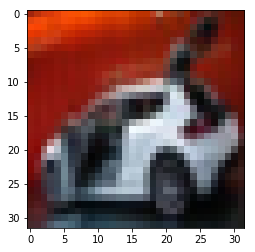

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import foolbox
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
%matplotlib inline

# Simple CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.convm1 = nn.Conv2d(10,10, kernel_size=3, padding=1)
        self.convm2 = nn.Conv2d(10,10, kernel_size=3, padding=1)
        self.convm3 = nn.Conv2d(10,10, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self, x):
        x = self.bn1(F.relu(F.max_pool2d(self.conv1(x), 2)))
        x = self.bn1(F.relu(self.convm1(x)))
        x = self.bn1(F.relu(self.convm2(x)))
        x = self.bn1(F.relu(self.convm3(x)))
        x = self.bn2(F.relu(F.max_pool2d(self.conv2(x), 2)))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
        
n_epochs = 3
batch_size_train = 64
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Data loading code
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)


net = VGG('VGG11')
x = torch.randn(2,3,32,32)


model = Net()
var_model = Variationalize(model)


                      
optimizer = optim.Adam(var_model.parameters(), lr=0.01)

def train(epoch):
    var_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = var_model(data)
        loss_error = F.nll_loss(output, target)
        
        loss_prior = var_model.prior_loss() / 60000
        loss = loss_error + loss_prior
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

for epoch in range(1, 2):
    train(epoch)
      
      
#examples = enumerate(test_loader)
#batch_idx, (data, target) = next(examples)

cifar10_trainset = torchvision.datasets.CIFAR10(root='./files', train=False, download=True, transform=None)
test_image_zero, test_target_zero = cifar10_trainset[6]

target = test_target_zero

loader = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = loader(test_image_zero).float()

plt.figure(0)
plt.imshow(test_image_zero)

data = Variable(data, requires_grad=True)
data = data.unsqueeze(0)  

# Test prediction
var_model.eval()
# Use PyVarInf's Sample wrapper to sample models from the variational distribution using draw()
var_model = Sample(var_model)
print(target)
for i in range (1, 10):
    data, target = data, target
    var_model.draw()
    result = var_model(data).detach()
    values, index = torch.max(result,1)
    conf = np.exp(result[0][index])
    print(index[0], conf)
        

# Convert data and target to Foolbox friendly format
data = data[:, :2]
data = data.data.cpu().numpy()
#target = target.data.cpu().numpy()

var_model.eval()
# Convert model to Foolbox model
fmodel = foolbox.models.PyTorchModel(
    var_model, bounds=(0, 1), num_classes=10)

print('label', target)
result = np.exp(fmodel.predictions(data))
pred = np.argmax(result)

# Black Box Attack Model
print('predicted class', pred, '| confidence', result[pred]);
# apply attack on source image
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(data, target)

im = Image.fromarray(np.uint8(adversarial[0]*255))
adversarial = loader(im).float()
adversarial = Variable(adversarial, requires_grad=True)
adversarial = adversarial.unsqueeze(0)  
for i in range (1, 10):
    attack_data = adversarial
    var_model.draw()
    result = var_model(attack_data).detach()
    values, index = torch.max(result,1)
    conf = np.exp(result[0][index])
    print(index[0], conf)
    
plt.figure(1)
plt.imshow(im)
plt.show()

